In [1]:
import time
import numpy as np
import tensorflow as tf
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from string import punctuation
import collections, operator
from scikitplot import plotters as skplt
import nltk
#scikit-learn package
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
#keras
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential, Model, save_model, load_model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Conv2D, MaxPooling2D, Reshape, merge, BatchNormalization, concatenate
from keras import backend as K
from keras.layers import Input, Flatten, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences, skipgrams, make_sampling_table
from keras.utils import np_utils
from keras.preprocessing.text import text_to_word_sequence
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.data_utils import get_file
#gensim
import gensim
from gensim.models import word2vec, Phrases, word2vec
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

Using TensorFlow backend.


## tweets data pre-processing step
1. Loading the data from json files into dataframes
2. Filtering the data with tweets text
3. Seperating the data frames based on the tweets type
4. finally 3 data frames with the following labels
    * tweets_food
        * Labels : healthy, junk, unhealthy
    * tweets_borne
        * Labels : relevant, irrelevant
    * tweets_exercise
        * Labels : relevant, irrelevant

In [2]:
#preparing the data
#json reading using pandas
tweets_pd = pd.read_json('classified_tweets_latest.json', orient='columns')
tweets_pd.head()
tweets_text = (tweets_pd['tweet'].apply(lambda tweet : eval(tweet))).apply(lambda tweet : tweet['text'])
tweets_pd = tweets_pd.assign(tweets_text = tweets_text)
#tweets_pd.label_data.value_counts()
#missing values checking for label_data
tweets_pd = tweets_pd.loc[tweets_pd['food'] != 'None']
tweets_pd = tweets_pd.loc[tweets_pd['label_data'] != '']
print(tweets_pd.shape)
tweets_pd['label_data'] = tweets_pd.label_data.str.lower()
tweets_pd['tweets_text'] = tweets_pd.tweets_text.apply(lambda x: ' '.join(re.sub(r"([!@#$]+)|([^A-Za-z .*\t])|(\w+:\/\/\S+)",' ',x).split()))
#after removing special characters, we left with plain data with alphanumeric characters
#seperate the data based on their class
tweets_pd_food = tweets_pd.loc[tweets_pd.food == '1']
tweets_pd_borne = tweets_pd.loc[tweets_pd.borne == '1']
tweets_pd_exercies = tweets_pd.loc[tweets_pd.exercise == '1']
print("tweets with food dataframe shape is {}".format(tweets_pd_food.shape))
print("tweets with borne dataframe shape is {}".format(tweets_pd_borne.shape))
print("tweets with exercises dataframe shape is {}".format(tweets_pd_exercies.shape))
pd_792017 = pd.read_json('07292017.json', orient='columns')
pd_8022017 = pd.read_json('08022017.json', orient='columns')
pd_8072017 = pd.read_json('08072017.json', orient='columns')
pd_8082017 = pd.read_json('08082017.json', orient='columns')
pd_8242017 = pd.read_json('08242017.json', orient='columns')
tweets_data = pd.concat([pd_792017, pd_8022017, pd_8072017, pd_8082017, pd_8242017], ignore_index=True)
tweets_data_text = (tweets_data.tweet.apply(lambda tweet: eval(tweet))).apply(lambda text: text['text'])
#data with 9 columns
tweets_data = tweets_data.assign(tweets_data_text = tweets_data_text)
#tweets_data_text.head()
#change the labels into category codes
tweets_data.food = tweets_data.food.astype("category")
print(tweets_data.shape)
#remove the tweets without label_data
print("data with labels {}".format(sum(tweets_data['label_data'] != '')))
print("removing data without labels")
#missing values checking for label_data
tweets_data = tweets_data.loc[tweets_data['label_data'] != '']
print("after removing the shape of the data is{}".format(tweets_data.shape))
tweets_data['label_data'] = tweets_data.label_data.str.lower()
tweets_data['tweets_text'] = tweets_data.tweets_data_text.apply(lambda x: ' '.join(re.sub(r"([!@#$]+)|([^A-Za-z .*\t])|(\w+:\/\/\S+)",' ',x).split()))
print(tweets_data.tweets_data_text.head())
#after removing special characters, we left with plain data with alphanumeric characters
#seperate the data based on their class
tweets_data_food = tweets_data.loc[tweets_data.food == 1]
tweets_data_borne = tweets_data.loc[tweets_data.borne == 1]
tweets_data_exercies = tweets_data.loc[tweets_data.exercise == 1]
tweets_data_food = tweets_data_food[['label_data','tweets_text']]
tweets_data_borne = tweets_data_borne[['label_data','tweets_text']]
tweets_data_exercies = tweets_data_exercies[['label_data','tweets_text']]
tweets_pd_food = tweets_pd_food[['label_data','tweets_text']]
tweets_pd_borne = tweets_pd_borne[['label_data','tweets_text']]
tweets_pd_exercies = tweets_pd_exercies[['label_data','tweets_text']]
tweets_food = pd.concat([tweets_data_food, tweets_pd_food])
tweets_borne = pd.concat([tweets_data_borne, tweets_pd_borne])
tweets_exercies = pd.concat([tweets_data_exercies, tweets_pd_exercies])
print("tweets with food dataframe shape is {}".format(tweets_food.shape))
print("tweets with borne dataframe shape is {}".format(tweets_borne.shape))
print("tweets with exercises dataframe shape is {}".format(tweets_exercies.shape))
#'healthy','unhealthy','junk','relevant','irrelevant'
food_labels = ['healthy','unhealthy','junk']
borne_labels = exercise_labels = ['junk','relevant','irrelevant']
tweets_food = tweets_food.loc[tweets_food.label_data.isin(food_labels)]
tweets_borne = tweets_borne.loc[tweets_borne.label_data.isin(borne_labels)]
tweets_exercies = tweets_exercies.loc[tweets_exercies.label_data.isin(exercise_labels)]

#tweets_data_food.label_data.value_counts()

(7294, 16)
tweets with food dataframe shape is (7294, 16)
tweets with borne dataframe shape is (470, 16)
tweets with exercises dataframe shape is (2201, 16)
(28246, 10)
data with labels 26922
removing data without labels
after removing the shape of the data is(26922, 10)
0    RT @_skull_queen_: So..... has anyone ever act...
1    RT @_skull_queen_: So..... has anyone ever act...
2    RT @_skull_queen_: So..... has anyone ever act...
3    RT @_skull_queen_: So..... has anyone ever act...
4    RT @_skull_queen_: So..... has anyone ever act...
Name: tweets_data_text, dtype: object
tweets with food dataframe shape is (19504, 2)
tweets with borne dataframe shape is (16550, 2)
tweets with exercises dataframe shape is (2469, 2)


In [3]:
#i find few duplicate rows, so deleting the duplicate rows
tweets_food = tweets_food.reset_index(drop=True)
print("before removing{}".format(tweets_food.shape))
tweets_food = tweets_food.drop_duplicates()
print("after removing{}".format(tweets_food.shape))
print("before removing{}".format(tweets_borne.shape))
tweets_borne = tweets_borne.drop_duplicates()
print("after removing{}".format(tweets_borne.shape))
print("before removing{}".format(tweets_exercies.shape))
tweets_exercies = tweets_exercies.drop_duplicates()
print("after removing{}".format(tweets_exercies.shape))

before removing(17894, 2)
after removing(11102, 2)
before removing(15505, 2)
after removing(7071, 2)
before removing(2447, 2)
after removing(2049, 2)


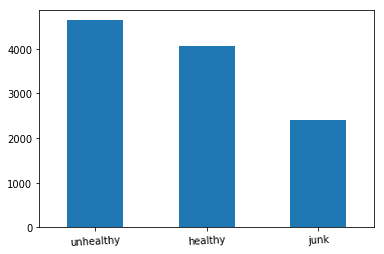

In [4]:
food_label_count = tweets_food.label_data.value_counts()
food_label_count.plot(kind = 'bar', rot=3)
plt.show()

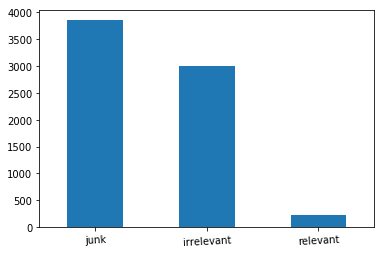

In [5]:
borne_label_count = tweets_borne.label_data.value_counts()
borne_label_count.plot(kind = 'bar', rot=3)
plt.show()

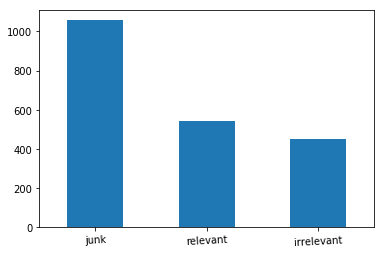

In [6]:
exercies_label_count = tweets_exercies.label_data.value_counts()
exercies_label_count.plot(kind = 'bar', rot=3)
plt.show()

In [7]:
tweets_borne.label_data = tweets_borne.label_data.apply(lambda x : "irrelevant" if x == "junk" else x)
tweets_exercies.label_data = tweets_exercies.label_data.apply(lambda x : "irrelevant" if x == "junk" else x)

## feature Engineering:
1. tweets text tokenization
2. tweets label conversion (one-hot encoding representation)

In [10]:
#since I am using skip-gram model I am not removing stop words
#tokenize text into array of words
stemmer=nltk.stem.SnowballStemmer('english')
def tokenizeData(pdSeries):
    #corpus = pdSeries.apply(lambda x: x.replace("\n","").split())
    corpus = [z.lower().replace('\n','').split() for z in pdSeries]
    return corpus

In [11]:
#before jump into models, I convert the categorical classes into one-hot encoding format
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(tweets_food['label_data'])
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = onehot_encoder.fit_transform(integer_encoded)
#print(tweets_food['label_data'])

## loading pretraineed 200 dimentional glove  word embedding from standford NLP library
1. assign the weights of each word vector of the corrsponding word if the word presents in word-embedding matrix

In [12]:
#loading pretrained word embeddings
embeddings_index = {}
f = open('glove.twitter.27B.200d.txt')
for line in f:
    #print(line)
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(tweets_food.tweets_text))
sequences = tokenizer.texts_to_sequences(list(tweets_food.tweets_text))
word_index = tokenizer.word_index
max_length = max(map(lambda x:len(x), tweets_food.tweets_text))
data = pad_sequences(sequences, maxlen=max_length)

In [14]:
#assin the embed vector to corresponding words in the tweet corpus
embed_dim = 200
embedding_matrix = np.random.random((len(word_index) + 1, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [15]:
#to save the model
def saveModel(file_name, model):
    #saving model to HDF5
    model.save("{}_model.h5".format(file_name))
    print("Saved model to disk")

In [16]:
def train_test_model(model, input_data, target, file_name):
    train_x, test_x, train_y, test_y = train_test_split(input_data, target, test_size = 0.2)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_x, train_y, batch_size= 20, validation_split= 0.2, epochs=20,  verbose=True)
    score = model.evaluate(test_x, test_y, verbose = 0)
    print("the loss {} and the accuracy score for test dataset is {}".format(score[0], score[1]))
    saveModel(file_name, model)

In [17]:
if os.path.isfile('glove_model.h5'):
    model = load_model('glove_model.h5')
    train_test_model(model, data, labels, "glove")
else:
    embedding_layer = Embedding(len(word_index) + 1,
                                embed_dim,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=True)

    sequence_input = Input(shape=(max_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(512, 4, activation='relu')(embedded_sequences)

    l_pool1 = MaxPooling1D(4)(l_cov1)
    l_cov2 = Conv1D(512, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_cov3 = Conv1D(512, 5, padding="same", activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(35, padding="same")(l_cov3)
    l_flat = Flatten()(l_pool3)
    dropout = Dropout(0.5)(l_flat)
    l_dense = Dense(128, activation='relu')(dropout)
    pred = Dense(3, activation='softmax', name = 'fc')(l_dense)
    model = Model(sequence_input, pred)
    print(model.summary())
    train_test_model(model, data, labels, "glove")

Train on 7104 samples, validate on 1777 samples
Epoch 1/20
7104/7104 [==============================] - 56s 8ms/step - loss: 0.5482 - acc: 0.7532 - val_loss: 0.5676 - val_acc: 0.7468
Epoch 2/20
7104/7104 [==============================] - 56s 8ms/step - loss: 0.5098 - acc: 0.7593 - val_loss: 0.5244 - val_acc: 0.7462
Epoch 3/20
7104/7104 [==============================] - 55s 8ms/step - loss: 0.4769 - acc: 0.7638 - val_loss: 0.5493 - val_acc: 0.7490
Epoch 4/20
7104/7104 [==============================] - 55s 8ms/step - loss: 0.5864 - acc: 0.7497 - val_loss: 0.8191 - val_acc: 0.7203
Epoch 5/20
7104/7104 [==============================] - 55s 8ms/step - loss: 0.5176 - acc: 0.7610 - val_loss: 0.5873 - val_acc: 0.7440
Epoch 6/20
7104/7104 [==============================] - 55s 8ms/step - loss: 0.4892 - acc: 0.7590 - val_loss: 0.5730 - val_acc: 0.7378
Epoch 7/20
7104/7104 [==============================] - 55s 8ms/step - loss: 0.4505 - acc: 0.7693 - val_loss: 0.5557 - val_acc: 0.7473
Epoch 8

In [18]:
# train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size = 0.2)
# x_train, val_x, y_train, val_y = train_test_split(train_x, train_y, test_size = 0.2) 
# model.fit(x_train, y_train, validation_data=(val_x, val_y), epochs = 20, batch_size = 20, verbose = False)
# score = model.evaluate(test_x, test_y, verbose = 0)
# print("the loss {} and the accuracy score for test dataset is {}".format(score[0], score[1]))

## till now we have seen the model perofrmance using tweet-glove preptrained glove-model now we will train the our own  word2vec:CBOW model for CNN classification'

In [19]:
def word_freq(all_vocabulary, freq):
    sorted_vocab = sorted(dict(collections.Counter(all_vocabulary)).items(), key=operator.itemgetter(1))
    final_vocab = [k for k,v in sorted_vocab if v>freq]
    word_idx = dict((c, i + 1) for i, c in enumerate(final_vocab))
    return final_vocab, word_idx

final_vocab, word_idx = word_freq(np.hstack(tokenizeData(tweets_food.tweets_text)),2)
vocab_len = len(final_vocab)

def sentenceToVect(data, word_idx, final_vocab, maxlen=40):
    X = []
    notexist = len(final_vocab)+2
    for sentences in data:
        x=[]
        for word in sentences.split(" "):
            if word in final_vocab:
                x.append(word_idx[word])
            else:
                x.append(notexist)
        X.append(x)
    return (pad_sequences(X, maxlen=maxlen))

max_length = 50
embed_dim = 150
train_data = sentenceToVect(tweets_food.tweets_text, word_idx, final_vocab, max_length)
final_vocab_len = vocab_len+3

In [20]:
if os.path.isfile('wordembed_model.h5'):
    model = load_model('wordembed_model.h5')
    train_test_model(model, train_data, labels, "wordembed")
else:
    sequence_input = Input(shape=(max_length,embed_dim), dtype='float32')
    from keras.layers.advanced_activations import LeakyReLU
    filter_sizes = (3,5,5,7)
    dropout_prob = [0.5,0.5]
    graph_in = sequence_input
    convs = []
    mul = 1
    for filter_s in filter_sizes:
        conv = Conv1D(filters=32*mul,
                             kernel_size=filter_s,
                             padding='valid',
                             activation='relu')(graph_in)
        pool = MaxPooling1D(max_length-filter_s+1)(conv)
        flattenMax = Flatten()(pool)
        convs.append(flattenMax)
        mul+=1
    out = concatenate(convs, axis=1)    
    graph = Model(graph_in, out, name="word_embed")
    model = Sequential()
    model.add(Embedding(input_dim=final_vocab_len, #size of vocabulary
                     output_dim = embed_dim,
                     input_length = max_length,
                     trainable=True))
    model.add(Dropout(dropout_prob[0]))
    model.add(graph)
    model.add(Dense(128, kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_prob[1]))
    #model.add(Activation('relu'))
    model.add(LeakyReLU(alpha=.001))
    model.add(Dense(3))
    #model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model.summary()
    train_test_model(model, train_data, labels, "wordembed")

Train on 7104 samples, validate on 1777 samples
Epoch 1/20
7104/7104 [==============================] - 9s 1ms/step - loss: 0.8815 - acc: 0.7221 - val_loss: 0.5364 - val_acc: 0.7935
Epoch 2/20
7104/7104 [==============================] - 9s 1ms/step - loss: 0.5677 - acc: 0.7690 - val_loss: 0.4914 - val_acc: 0.8070
Epoch 3/20
7104/7104 [==============================] - 9s 1ms/step - loss: 0.4915 - acc: 0.8012 - val_loss: 0.4742 - val_acc: 0.8109
Epoch 4/20
7104/7104 [==============================] - 9s 1ms/step - loss: 0.4192 - acc: 0.8340 - val_loss: 0.4810 - val_acc: 0.8087
Epoch 5/20
7104/7104 [==============================] - 9s 1ms/step - loss: 0.3492 - acc: 0.8623 - val_loss: 0.5076 - val_acc: 0.7997
Epoch 6/20
7104/7104 [==============================] - 9s 1ms/step - loss: 0.2963 - acc: 0.8832 - val_loss: 0.5098 - val_acc: 0.8104
Epoch 7/20
7104/7104 [==============================] - 9s 1ms/step - loss: 0.2612 - acc: 0.9019 - val_loss: 0.5450 - val_acc: 0.8047
Epoch 8/20
710

## word2vec- skip gram model
1. given the target of the word predicts the context of the input word

In [23]:
max_length = 15
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer.fit_on_texts(tweets_food.tweets_text)
sequences = tokenizer.texts_to_sequences(list(tweets_food.tweets_text))
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=max_length)
#vocab size
vocab_len = len(tokenizer.word_index) + 1

In [24]:
embedding_size = 200
number_of_epochs = 20
num_neg_samples = 4
sampling_factor = 1e-1
window_size = 4
save_path = './tweets_food_model.txt'

In [25]:
from keras.layers import Activation, Embedding, Merge, Reshape
def create_model():
    target_word = Sequential()
    target_word.add(Embedding(vocab_len, embedding_size, input_length=1))

    context = Sequential()
    context.add(Embedding(vocab_len, embedding_size, input_length=3))

    model = Sequential()
    model.add(Merge([target_word, context], mode='dot', dot_axes=2))
    model.add(Reshape((1,), input_shape=(1, 1)))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [26]:
def train_model(model):
    sampling_table = make_sampling_table(vocab_len, sampling_factor=sampling_factor)
    for epoch in range(number_of_epochs):
        loss = 0.
        for i, sentence in enumerate(sequences):
            if i % 500 == 0:
                print('{}/{}'.format(i, len(sequences)))
            couples, labels = skipgrams(sequence=sentence, vocabulary_size=vocab_len, window_size=window_size,
                                        negative_samples=num_neg_samples, sampling_table=sampling_table)
            if couples:
                words, contexts = zip(*couples)
                words = np.array(words, dtype=np.int32)
                contexts = np.array(contexts, dtype=np.int32)
                y = np.array(labels, dtype=np.int32)
                loss += model.train_on_batch([words, contexts], y)
        print('epoch finished: {} with loss: {}'.format(epoch, loss))

    return model

In [30]:
def save_model(model):
    with open(save_path, 'w') as f:
        f.write(' '.join([str(vocab_len - 1), str(embedding_size)]))
        f.write('\n')
        vectors = model.get_weights()[0]
        for word, i in tokenizer.word_index.items():
            f.write(word)
            f.write(' ')
            f.write(' '.join(map(str, list(vectors[0][i, :]))))
            f.write('\n')

In [21]:
# load embedding as a dict
def load_embedding(filename):
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        words = line.split()
        # key is string word, value is numpy array for vector
        embedding[words[0]] = np.asarray(words[1:], dtype='float32')
    return embedding

In [22]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    #total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    #define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, embedding_size))
    #step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [31]:
if os.path.isfile(save_path):
    pass
else:
    model = create_model()
    model = train_model(model)
    save_model(model)

In [37]:
# load embedding from file and create the embedding layer
raw_embedding = load_embedding('tweets_food_model.txt')
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
embedding_layer = Embedding(vocab_len, embedding_size, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [38]:
# define model
def defineModel(max_sequence_length, embed_dim, embedding_layer):
    sequence_input = Input(shape=(max_sequence_length,embed_dim), dtype='float32')
    filter_sizes = (3,5,5,7)
    dropout_prob = [0.5,0.5]
    convs = []
    mul = 1
    for filter_s in filter_sizes:
        conv = Conv1D(filters=32*mul,
                             kernel_size=filter_s,
                             padding='valid',
                             activation='relu')(sequence_input)
        pool = MaxPooling1D(max_length-filter_s)(conv)
        flattenMax = Flatten()(pool)
        convs.append(flattenMax)
        mul+=1
    out = concatenate(convs, axis=1)    
    graph = Model(sequence_input, out, name="word2vec")
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(dropout_prob[0]))
    model.add(graph)
    model.add(Dense(128, kernel_initializer='uniform'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(LeakyReLU(alpha=.001))
    model.add(Dense(3))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    return model

In [39]:
if os.path.isfile('skipgram_model.h5'):
    model = load_model('skipgram_model.h5')
    train_test_model(model, data, labels,"skipgram")
else:
    model = defineModel(max_length, embedding_size, embedding_layer)
    print(model.summary())
    train_test_model(model, data, labels, "skipgram")

Train on 7104 samples, validate on 1777 samples
Epoch 1/20
7104/7104 [==============================] - 3s 411us/step - loss: 0.2276 - acc: 0.9216 - val_loss: 0.0761 - val_acc: 0.9764
Epoch 2/20
7104/7104 [==============================] - 3s 361us/step - loss: 0.2104 - acc: 0.9251 - val_loss: 0.0760 - val_acc: 0.9758
Epoch 3/20
7104/7104 [==============================] - 3s 362us/step - loss: 0.1986 - acc: 0.9329 - val_loss: 0.0797 - val_acc: 0.9736
Epoch 4/20
7104/7104 [==============================] - 3s 361us/step - loss: 0.1934 - acc: 0.9319 - val_loss: 0.0859 - val_acc: 0.9730
Epoch 5/20
7104/7104 [==============================] - 3s 359us/step - loss: 0.1804 - acc: 0.9396 - val_loss: 0.0865 - val_acc: 0.9741
Epoch 6/20
7104/7104 [==============================] - 3s 359us/step - loss: 0.1723 - acc: 0.9407 - val_loss: 0.0927 - val_acc: 0.9679
Epoch 7/20
7104/7104 [==============================] - 3s 362us/step - loss: 0.1620 - acc: 0.9437 - val_loss: 0.0981 - val_acc: 0.9713


## Gradient Boosting Classifier with doc2vec model

In [40]:
tweets_food = tweets_food.reset_index(drop=True)
#transform the tweets text into the doc2vec compatible input format
def label_sentences(df):
    labeled_sentences = []
    for index, row in df.iterrows():
        #print(index)
        tokenized_words = row["tweets_text"].lower().split(" ")
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['label{}'.format(index)]))
    return labeled_sentences

#trains the doc2vec model
def tweets_doc2vec_model(labeled_sentences):
    model = Doc2Vec(alpha=0.01, min_alpha=0.01, min_count = 2)
    model.build_vocab(labeled_sentences)
    for epoch in range(10):
        model.train(labeled_sentences)
        model.alpha -= 0.002 
        model.min_alpha = model.alpha
    return model

seq = label_sentences(tweets_food)
model = tweets_doc2vec_model(seq)

In [45]:
def vectorize_tweets(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        label = 'label{}'.format(i)
        comments.append(d2v_model.docvecs[label])
    df['vectorized_tweets'] = comments    
    return df

def train_classifier(X,y):
    n_estimators = [500]
    min_samples_split = [4]
    min_samples_leaf = [3]

    parameters = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split}

    clf = GridSearchCV(GradientBoostingClassifier(random_state=7), cv=5, param_grid=parameters)
    clf.fit(X, y)
    return clf

doc2vec_df = vectorize_tweets(tweets_food, model)
print (doc2vec_df.head(2))

   label_data                                        tweets_text  \
0           2  Note to self don t eat scones before training ...   
1           0  I feel like my body is trying to get sick but ...   

                                   vectorized_tweets  
0  [-0.0965432, 0.08884, -0.0701348, -0.0383165, ...  
1  [-0.00250567, -0.090926, 0.0238593, 0.0058652,...  


In [47]:
doc2vec_df.label_data = doc2vec_df.label_data.astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(doc2vec_df.vectorized_tweets.T.tolist(), doc2vec_df.label_data, test_size=0.15, random_state=17)
classifier = train_classifier(X_train,y_train)
print (classifier.best_score_, "is the accuracy score of the best possible model on validation set")
print (classifier.score(X_test,y_test))

0.537409919457 is the accuracy score of the best possible model on validation set
0.541416566627
